## Needed Imports

In [1]:
from collections import defaultdict
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from pathlib import Path
from typing import Union
import numpy as np
import kornia
import torch
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from tqdm.auto import tqdm
import pandas as pd
from SoccerNet.Evaluation.utils_calibration import SoccerPitch
import torchvision
import pytorch_lightning
from tvcalib.cam_modules import SNProjectiveCamera
from tvcalib.module import TVCalibModule
from tvcalib.cam_distr.tv_main_center import get_cam_distr, get_dist_distr
from sn_segmentation.src.custom_extremities import generate_class_synthesis, get_line_extremities
from tvcalib.sncalib_dataset import custom_list_collate, split_circle_central
from tvcalib.utils.io import detach_dict, tensor2list
from tvcalib.utils.objects_3d import SoccerPitchLineCircleSegments, SoccerPitchSNCircleCentralSplit
from tvcalib.inference import InferenceDatasetCalibration, InferenceDatasetSegmentation, InferenceSegmentationModel
from tvcalib.inference import get_camera_from_per_sample_output
from tvcalib.utils import visualization_mpl_min as viz
from kornia_utlis import homography_warp
torch.set_printoptions(precision=4, sci_mode=False)
import os
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt


/home/romaisaa/miniconda3/envs/new-cam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 10


## Setting Needed Var

In [2]:
image_path = "data/datasets/wc14-test5/12.jpg"
images_path = Path(os.path.dirname(image_path))  #images paths
with Image.open(image_path) as img:
       image_width, image_height = img.size
checkpoint="data/segment_localization/train_59.pt"
output_dir=Path("tmp")
nworkers = 8
batch_size_seg=16
batch_size_calib=256
lens_dist=False
write_masks=False
optim_steps=2000
test_points = torch.tensor([[990, 370],[880, 500] ])

In [3]:
device = "cuda"
object3d = SoccerPitchLineCircleSegments(
    device=device, base_field=SoccerPitchSNCircleCentralSplit()
)
object3dcpu = SoccerPitchLineCircleSegments(
    device="cpu", base_field=SoccerPitchSNCircleCentralSplit()
)
lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

fn_generate_class_synthesis = partial(generate_class_synthesis, radius=4)
fn_get_line_extremities = partial(get_line_extremities, maxdist=30, width=455, height=256, num_points_lines=4, num_points_circles=8)

## Model Inference

In [4]:
dataset_seg = InferenceDatasetSegmentation(
    images_path, image_width, image_height
)
print("number of images:", len(dataset_seg))
dataloader_seg = torch.utils.data.DataLoader(
    dataset_seg,
    batch_size=batch_size_seg,
    num_workers=nworkers,
    shuffle=False,
    collate_fn=custom_list_collate,
)

model_seg = InferenceSegmentationModel(checkpoint, device)

image_ids = []
keypoints_raw = []
(output_dir / "masks").mkdir(parents=True, exist_ok=True)
for batch_dict in tqdm(dataloader_seg):
    with torch.no_grad():
        sem_lines = model_seg.inference(batch_dict["image"].to(device))
    sem_lines = sem_lines.cpu().numpy().astype(np.uint8)  # [B, 256, 455]

    # point selection
    with Pool(nworkers) as p:
        skeletons_batch = p.map(fn_generate_class_synthesis, sem_lines)
        keypoints_raw_batch = p.map(fn_get_line_extremities, skeletons_batch)

    # write to file
    if write_masks:
        print("Write masks to file")
        for image_id, mask in zip(batch_dict["image_id"], sem_lines):
            mask = Image.fromarray(mask.astype(np.uint8)).convert("P")
            mask.putpalette(lines_palette)
            mask.convert("RGB").save(output_dir / "masks" / image_id)

    image_ids.extend(batch_dict["image_id"])
    keypoints_raw.extend(keypoints_raw_batch)

number of images: 1


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


In [5]:
model_calib = TVCalibModule(
    object3d,
    get_cam_distr(1.96, batch_size_calib, 1),
    get_dist_distr(batch_size_calib, 1) if lens_dist else None,
    (image_height, image_width),
    optim_steps,
    device,
    log_per_step=False,
    tqdm_kwqargs=None,
)

dataset_calib = InferenceDatasetCalibration(keypoints_raw, image_width, image_height, object3d)
dataloader_calib = torch.utils.data.DataLoader(dataset_calib, batch_size_calib, collate_fn=custom_list_collate)

per_sample_output = defaultdict(list)
per_sample_output["image_id"] = [[x] for x in image_ids]
for x_dict in dataloader_calib:
    _batch_size = x_dict["lines__ndc_projected_selection_shuffled"].shape[0]

    points_line = x_dict["lines__px_projected_selection_shuffled"]
    points_circle = x_dict["circles__px_projected_selection_shuffled"]
    print(f"{points_line.shape=}, {points_circle.shape=}")

    per_sample_loss, cam, _ = model_calib.self_optim_batch(x_dict)
    output_dict = tensor2list(detach_dict({**cam.get_parameters(_batch_size), **per_sample_loss}))

    output_dict["points_line"] = points_line
    output_dict["points_circle"] =  points_circle
    for k in output_dict.keys():
        per_sample_output[k].extend(output_dict[k])

df = pd.DataFrame.from_dict(per_sample_output)

df = df.explode(column=[k for k, v in per_sample_output.items() if isinstance(v, list)])
df.set_index("image_id", inplace=True, drop=False)

/home/romaisaa/miniconda3/envs/new-cam/lib/python3.8/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


points_line.shape=torch.Size([1, 1, 3, 23, 4]), points_circle.shape=torch.Size([1, 1, 3, 4, 8])


100%|██████████| 2000/2000 [00:24<00:00, 81.97it/s, loss=0.01039, loss_circles=0.007, loss_lines=0.003]


In [6]:
sample = df.iloc[0]

## Points Projection

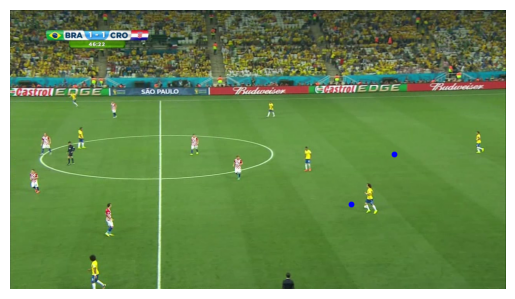

In [7]:
image_pil = Image.open(image_path).convert("RGB")
image = TF.to_tensor(image_pil)
image_np = (image * 255.).permute(1, 2, 0).to(torch.uint8).numpy()
fig, ax = plt.subplots()
ax.imshow(image_np)
for point in test_points:
    ax.scatter(point[0], point[1], s=10, c='b', marker='o')
ax.axis('off')
plt.show()



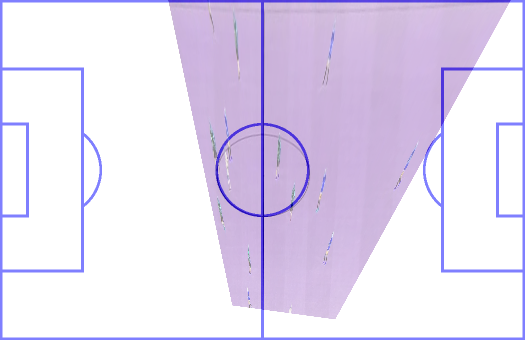

In [8]:
h = torch.tensor(sample["homography"])

target_scale = 5
S = torch.eye(3).unsqueeze(0)
S[:, 0, 0] = S[:, 1, 1] = target_scale
# translate center of the homography matrix to the correct image origin (upper left)
T = torch.eye(3).unsqueeze(0)
T[:, 0, -1] = 105 / 2
T[:, 1, -1] = 68 / 2


def _warp_img(image, H):
    # scaling matrix for better image resolution
    warped_top = homography_warp(
        image.unsqueeze(0),
        S @ T @ H,
        dsize=(int(68 * target_scale), int(105 * target_scale)),
        normalized_homography=False,
        normalized_coordinates=False,
        mode="nearest",
    ).squeeze()
    return warped_top

# image_mask = torch.ones(3, 720, 1280, dtype=torch.float)
# mask = _warp_img(image_mask, h)
mask = _warp_img(image, h)
# mask = torch.permute(mask, (1, 2, 0))
mask = mask.permute(1, 2, 0).contiguous() 
mask = (mask * 255).to(torch.uint8)
mask = 255 - mask

# overlay with template
ftemplate = Path("template_pitch_t.png")
template = torchvision.transforms.functional.to_tensor(Image.open(ftemplate).convert("RGB"))
template = torchvision.transforms.functional.resize(template, (int(target_scale*68), int(target_scale*105)))
# template = torch.permute(template, (1, 2, 0))
template = template.permute(1, 2, 0).contiguous() 
template = (template * 255).to(torch.uint8)

background = Image.fromarray(template.numpy()) # [:, :, :3]
foreground = Image.fromarray(mask.numpy())
blended = Image.blend(background, foreground, alpha=0.5)
blended

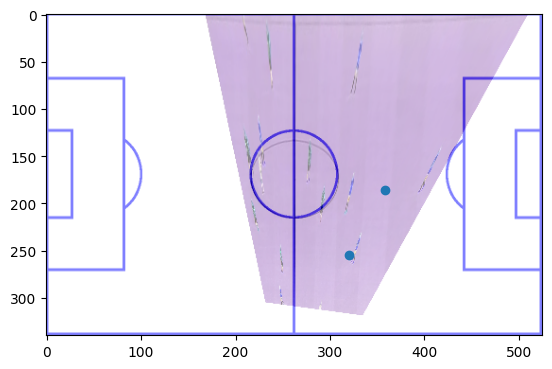

In [9]:
points_image = kornia.geometry.conversions.convert_points_to_homogeneous(test_points) # (?, 3)
points_image = points_image.transpose(0, 1) # (3, ?)
points_image = points_image.float()
h_img2img = (S @ T @ h).squeeze(0)
projected_points = (h_img2img @ points_image)
projected_points = projected_points/(projected_points[-1] + 1e-8)
plt.imshow(blended)
plt.scatter(projected_points[0], projected_points[1])
plt.show()


## Segementation Visualization

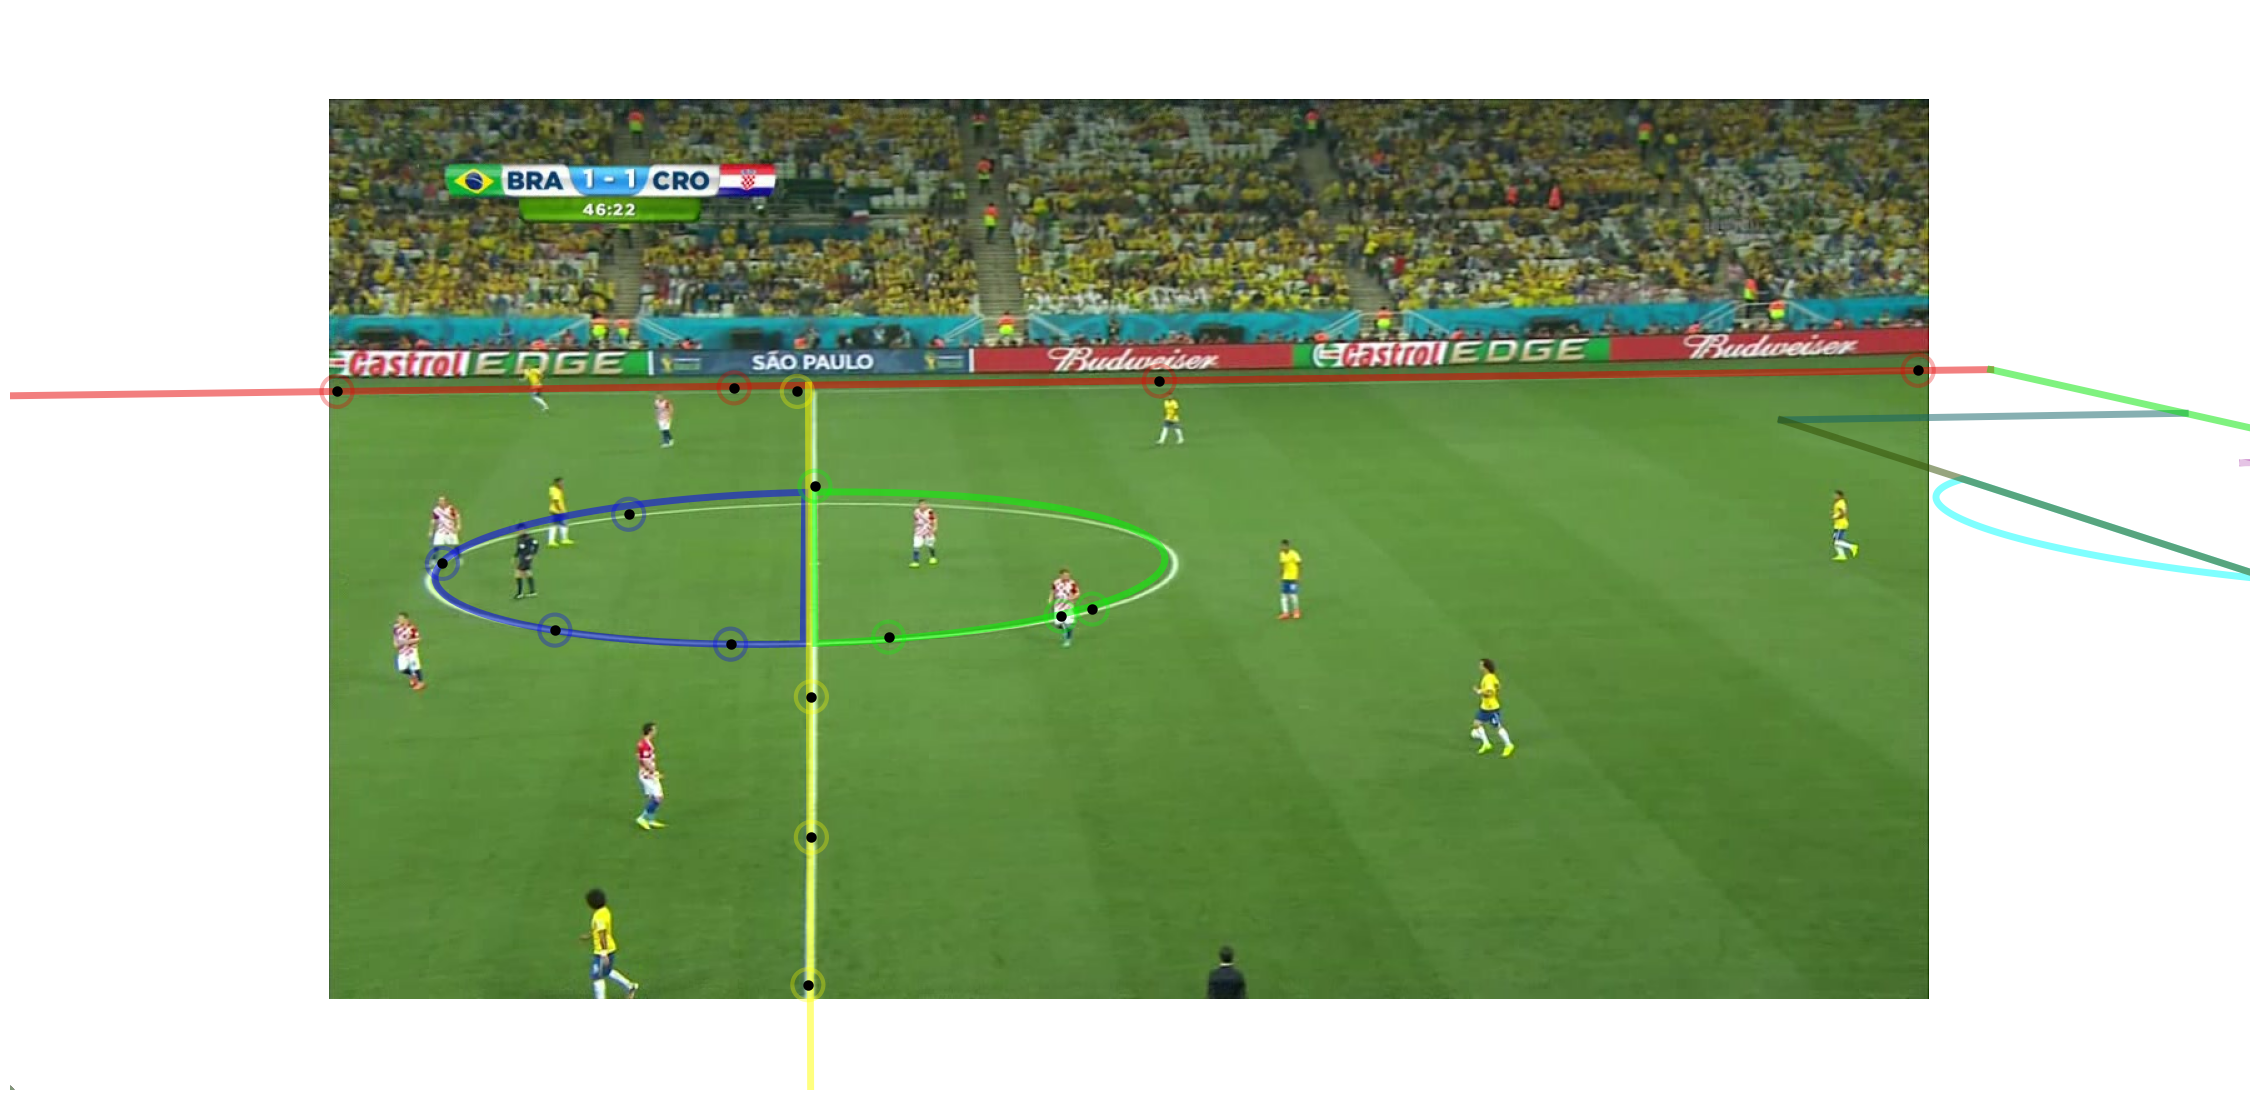

In [10]:
sample = df.iloc[0]

image_id = Path(sample.image_id).stem
# print(f"{image_id=}")
image = Image.open(images_path / sample.image_id).convert("RGB")
image = torchvision.transforms.functional.to_tensor(image)

cam = get_camera_from_per_sample_output(sample, lens_dist)
# print(cam, cam.str_lens_distortion_coeff(b=0) if lens_dist else "")
points_line, points_circle = sample["points_line"], sample["points_circle"]

if lens_dist:
    # we visualize annotated points and image after undistortion
    image = cam.undistort_images(image.unsqueeze(0).unsqueeze(0)).squeeze()
    # print(points_line.shape) # expected: (1, 1, 3, S, N)
    points_line = SNProjectiveCamera.static_undistort_points(points_line.unsqueeze(0).unsqueeze(0), cam).squeeze()
    points_circle = SNProjectiveCamera.static_undistort_points(points_circle.unsqueeze(0).unsqueeze(0), cam).squeeze()
else:
    psi = None


fig, ax = viz.init_figure(image_width, image_height)
ax = viz.draw_image(ax, image)
ax = viz.draw_reprojection(ax, object3dcpu, cam)
ax = viz.draw_selected_points(
    ax,
    object3dcpu,
    points_line,
    points_circle,
    kwargs_outer={
        "zorder": 1000,
        "rasterized": False,
        "s": 500,
        "alpha": 0.3,
        "facecolor": "none",
        "linewidths": 3,
    },
    kwargs_inner={
        "zorder": 1000,
        "rasterized": False,
        "s": 50,
        "marker": ".",
        "color": "k",
        "linewidths": 4.0,
    },
)
dpi = 50
plt.savefig(output_dir / f"{image_id}.png", dpi=dpi)